# I - Introduction

# II - Prepare required frameworks

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier as GBC
import lightgbm as lgbm
from sklearn.feature_selection import mutual_info_classif
from scipy import stats

In [242]:
import warnings

# Ẩn tất cả các cảnh báo
warnings.filterwarnings('ignore')

In [243]:
# from sklearnex import patch_sklearn

In [244]:
# patch_sklearn()

# III - Prepare dataset

# 1. Load dataset

In [245]:
dataset = pd.read_excel('./Dry_Bean_Dataset.xlsx')

In [246]:
# dataset.info()

In [247]:
# dataset.duplicated().sum()

In [248]:
dataset = dataset.set_index('Bean ID')

In [249]:
dataset.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

In [250]:
features = dataset.columns[:-1]
target = dataset.columns[-1]

In [251]:
# x.describe()

In [252]:
x = dataset[features]
y = dataset[target]

In [253]:
scaler = StandardScaler()
encoder = LabelEncoder()

In [254]:
# dataset['Class'] = pd.DataFrame(encoder.fit_transform(dataset['Class']), columns=['Class'])

In [255]:
pd.DataFrame(encoder.fit_transform(dataset['Class']), columns=['Class']).value_counts()

Class
3        3546
6        2636
5        2027
4        1928
2        1630
0        1322
1         522
Name: count, dtype: int64

In [256]:
# dataset['Class'].value_counts()

In [257]:
def prepare_data(dataset, features, target, scaler, encoder):
    x = dataset[features]
    y = dataset[target]
    x_scaled = scaler.fit_transform(x)
    y_encoded = encoder.fit_transform(y)
    x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_encoded, test_size=0.2, random_state=20)
    return x_train, x_test, y_train, y_test

In [258]:
x_train, x_test, y_train, y_test = prepare_data(dataset, features, target, scaler, encoder)

# Training models

In [259]:
models = {
    "KNeighbors": KNC(),
    "LogisticRegression": LR(),
    "RandomForest": RFC(),
    "SVC": SVC(),
    # "GradientBoosting": GBC(),
    "LightGBM": lgbm.LGBMClassifier(verbose=-1)
}

def get_scores(models, xtrain, ytrain, xtest, ytest):
    for name, model in models.items():
        print(f"-----> {name}")
        model.fit(xtrain, ytrain)
        ypred = model.predict(xtest)
        model.score(xtest, ytest)
        print("---> Model score: ", model.score(xtest, ytest))
        reports = classification_report(ytest, ypred)
        print("---> Classification_reports: \n", reports)
        
        # scores = np.mean(cross_val_score(model, xtrain, ytrain, cv=5))
        # print("---> Cross-validation scores: \n", scores)
        print("============================================\n")

In [260]:
get_scores(models, x_train, y_train, x_test, y_test)

-----> KNeighbors
---> Model score:  0.9214102093279471
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.96      0.88      0.92       279
           1       1.00      1.00      1.00       103
           2       0.93      0.95      0.94       332
           3       0.91      0.93      0.92       714
           4       0.94      0.95      0.95       342
           5       0.96      0.93      0.94       427
           6       0.86      0.88      0.87       526

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723


-----> LogisticRegression
---> Model score:  0.9247153874403232
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       279
           1       1.00      1.00      1.00       103
           2       0.94      0.95      0.95       332
   

# EDA

# Các thuộc tính
Area (A)	Diện tích:	Diện tích vùng của hạt đậu và số pixel nằm trong ranh giới của nó.

Perimeter (P)	Chu vi:	Chu vi của hạt đậu được định nghĩa là độ dài của đường viền.

Major axis length (L)	Độ dài trục chính:	Khoảng cách giữa hai đầu của đường thẳng dài nhất có thể vẽ trên hạt đậu.

Minor axis length (l)	Độ dài trục phụ:	Đường thẳng dài nhất có thể vẽ trên hạt đậu theo hướng vuông góc với trục chính.

Aspect ratio (K)	Tỷ lệ dài rộng:	Xác định mối quan hệ giữa L và l.

Eccentricity (Ec)	Độ lệch tâm:	Độ lệch tâm của hình elip có cùng các mô men như vùng hạt đậu.

Convex area (C)	Diện tích lồi:	Số pixel trong đa giác lồi nhỏ nhất có thể chứa diện tích của hạt đậu.

Equivalent diameter (Ed)	Đường kính tương đương:	Đường kính của một hình tròn có cùng diện tích với diện tích của hạt đậu.

Extent (Ex)	Độ bao phủ:	Tỷ lệ giữa số pixel trong khung bao và diện tích của hạt đậu.

Solidity (S)	Độ đặc:	Còn được gọi là độ lồi. Tỷ lệ giữa số pixel trong vỏ lồi và số pixel tìm thấy trong hạt đậu.

Roundness (R)	Độ tròn:	Được tính toán bằng công thức: (4piA)/(P^2)

Compactness (CO)	Độ gọn:	Đo độ tròn của một vật thể: Ed/L

ShapeFactor1 (SF1)	Hệ số hình dạng 1:	Tham số hình dạng bổ sung.

ShapeFactor2 (SF2)	Hệ số hình dạng 2:	Tham số hình dạng bổ sung.

ShapeFactor3 (SF3)	Hệ số hình dạng 3:	Tham số hình dạng bổ sung.

ShapeFactor4 (SF4)	Hệ số hình dạng 4:	Tham số hình dạng bổ sung.

Class (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz and Sira)	Lớp	Thuộc tính này phân loại hạt đậu thành các loại khác nhau: Seker, Barbunya, Bombay, Cali, Dermosan, Horoz và Sira.


<Axes: xlabel='Types of bean', ylabel='Count'>

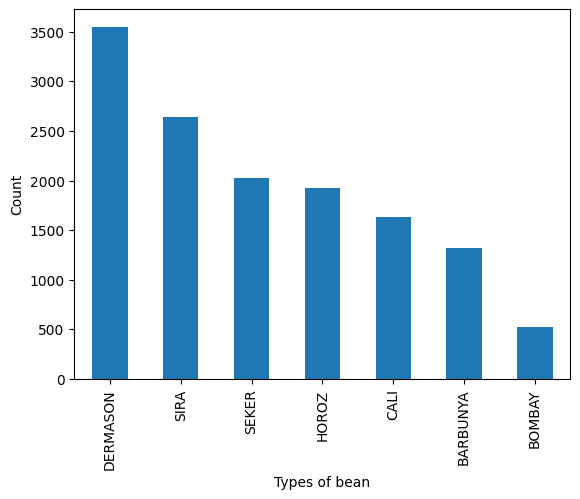

In [261]:
dataset['Class'].value_counts().plot(kind='bar', xlabel='Types of bean', ylabel='Count')

### Drop outliner

In [262]:
data_heads = x.columns
data_heads

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [263]:
# # Biều đồ hist thêm đường trung vị
# fig, axes = plt.subplots(4,4, figsize = (24,24))
# for i, axe in enumerate(axes.flatten()):
#     sns.histplot(data = x[data_heads[i]], ax = axe)
#     median = x[data_heads[i]].median()
#     axe.set_title(f'{data_heads[i]} (Median = {median:0.1f})')
#     axe.axvline(median, color='red', lw=2, alpha=1)

In [264]:
# # Biều đồ Boxplot để xem nhiễu
# fig, axes = plt.subplots(4, 4, figsize=(24,24))
# for i,axe in enumerate(axes.flatten()):
#     sns.boxplot(data = x[data_heads[i]], ax = axe)
#     axe.set_title(f'{data_heads[i]}')
# plt.tight_layout()

In [265]:
# fig, axes = plt.subplots(8, 2, figsize=(24,48))
# for feature, ax in zip(x.columns, axes.flatten()):
#     sns.violinplot(data = dataset, x = 'Class', y = feature, ax = ax, inner="quartile" )
#     ax.set(xlabel = None)
#     ax.set_title(f'Phân bố {feature} từng loại')

In [266]:
def drop_outliers(dataset, features):
    # Tính toán Z-score cho mỗi điểm dữ liệu
    z_scores = stats.zscore(dataset[features])

    # Xác định ngưỡng cho Z-score
    threshold = 3

    # Loại bỏ các outlier
    dataset_cleaned = dataset.loc[(z_scores < threshold).all(axis=1)]

    # In ra số lượng outlier đã loại bỏ
    outliers_removed = dataset.shape[0] - dataset_cleaned.shape[0]
    print("Số lượng outlier đã loại bỏ:", outliers_removed)
    return dataset_cleaned

In [267]:
dataset_cleaned = drop_outliers(dataset, features)
x_train, x_test, y_train, y_test = prepare_data(dataset_cleaned, features, target, scaler, encoder)
get_scores(models, x_train, y_train, x_test, y_test)

Số lượng outlier đã loại bỏ: 537
-----> KNeighbors
---> Model score:  0.9116634799235181
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.94      0.88      0.91       275
           1       1.00      1.00      1.00         3
           2       0.93      0.94      0.93       344
           3       0.91      0.90      0.91       697
           4       0.94      0.94      0.94       359
           5       0.95      0.94      0.94       408
           6       0.84      0.88      0.86       529

    accuracy                           0.91      2615
   macro avg       0.93      0.93      0.93      2615
weighted avg       0.91      0.91      0.91      2615


-----> LogisticRegression
---> Model score:  0.9162523900573614
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       275
           1       1.00      1.00      1.00         3
           2       0.95 

### Drop large corr

In [268]:
# # correlation matrix
# plt.figure(figsize=(20,20))
# sns.heatmap(x.corr(),annot = True, cmap = 'viridis_r', fmt = '.2f');

In [269]:
def drop_corr(dataset, features):
    # Đọc dữ liệu từ file CSV hoặc tạo ma trận tương quan từ dữ liệu hiện có
    corr_matrix = dataset[features].corr().abs()

    # Chọn ngưỡng tương quan
    threshold = 0.8

    # Tạo một bản sao của ma trận tương quan
    mask = corr_matrix.copy()

    # Thiết lập giá trị True cho các ô phía trên đường chéo chính
    # mask[np.triu_indices_from(mask.values)] = 0

    for i in range(len(mask.columns)):
        for j in range(i + 1):
            mask.iloc[i,j] = 0

    # print(mask)
    # Loại bỏ các biến dựa trên ngưỡng tương quan
    drop_cols = [column for column in mask.columns if any(mask[column] > threshold)]

    # Loại bỏ các cột từ DataFrame
    dataset_filtered = dataset.drop(drop_cols, axis=1)
    return dataset_filtered

In [270]:
dataset_filtered = drop_corr(dataset_cleaned, features)

In [271]:
x_train, x_test, y_train, y_test = prepare_data(dataset_filtered, dataset_filtered.columns[:-1], dataset_filtered.columns[-1], scaler, encoder)

In [272]:
get_scores(models, x_train, y_train, x_test, y_test)

-----> KNeighbors
---> Model score:  0.9105162523900574
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       275
           1       1.00      1.00      1.00         3
           2       0.92      0.95      0.93       344
           3       0.91      0.90      0.91       697
           4       0.95      0.95      0.95       359
           5       0.95      0.93      0.94       408
           6       0.83      0.88      0.85       529

    accuracy                           0.91      2615
   macro avg       0.93      0.93      0.93      2615
weighted avg       0.91      0.91      0.91      2615


-----> LogisticRegression
---> Model score:  0.9158699808795411
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       275
           1       1.00      1.00      1.00         3
           2       0.95      0.93      0.94       344
   

In [273]:
# Strongly_corr_features = dataset[["Area","Perimeter","AspectRation","Eccentricity","roundness","Compactness","Class"]]
# Strongly_corr_features.head()
# sns.set_theme(style="whitegrid")
# sns.pairplot(Strongly_corr_features, hue="Class")

In [274]:
dataset.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

In [275]:
mi_scores = mutual_info_classif(x, y, random_state = 31)
mi_scores_df = pd.DataFrame({'Feature': x.columns, 'MI Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False).reset_index(drop=True)

# plt.figure(figsize=(20,10))
# sns.barplot(x='MI Score', y='Feature', data=mi_scores_df) 
# plt.xlabel('Mutual Information Score')
# # plt.ylabel('Feature')
# plt.title('Mutual Information Scores for Each Feature')
# # plt.gca().invert_yaxis() # sắp xếp lại theo giảm dần
# plt.show()

### Drop large corr and outliner

In [276]:
data = drop_corr(dataset_cleaned, features)
x_train, x_test, y_train, y_test = prepare_data(data, data.columns[:-1], data.columns[-1], scaler, encoder)
get_scores(models, x_train, y_train, x_test, y_test)

-----> KNeighbors
---> Model score:  0.9105162523900574
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.95      0.87      0.91       275
           1       1.00      1.00      1.00         3
           2       0.92      0.95      0.93       344
           3       0.91      0.90      0.91       697
           4       0.95      0.95      0.95       359
           5       0.95      0.93      0.94       408
           6       0.83      0.88      0.85       529

    accuracy                           0.91      2615
   macro avg       0.93      0.93      0.93      2615
weighted avg       0.91      0.91      0.91      2615


-----> LogisticRegression
---> Model score:  0.9158699808795411
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.94      0.91      0.92       275
           1       1.00      1.00      1.00         3
           2       0.95      0.93      0.94       344
   

# * Data augmentation

## ** SMOTE

In [277]:
! pip install imbalanced-learn


In [278]:
from imblearn.over_sampling import SMOTE

In [279]:
x_train, x_test, y_train, y_test = prepare_data(dataset, dataset.columns[:-1], dataset.columns[-1], scaler, encoder)

In [280]:
x_train.shape

(10888, 16)

In [281]:
smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# for i in range(4):
#     x_train_resampled, y_train_resampled = smote.fit_resample(x_train_resampled, y_train_resampled)
print(x_train_resampled.shape)    
print(y_train_resampled.shape)

get_scores(models, x_train_resampled, y_train_resampled, x_test, y_test)

(19824, 16)
(19824,)
-----> KNeighbors
---> Model score:  0.9192067572530297
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.94      0.90      0.92       279
           1       1.00      1.00      1.00       103
           2       0.94      0.94      0.94       332
           3       0.93      0.91      0.92       714
           4       0.93      0.95      0.94       342
           5       0.94      0.94      0.94       427
           6       0.85      0.88      0.87       526

    accuracy                           0.92      2723
   macro avg       0.93      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723


-----> LogisticRegression
---> Model score:  0.9225119353654058
---> Classification_reports: 
               precision    recall  f1-score   support

           0       0.95      0.91      0.93       279
           1       1.00      1.00      1.00       103
           2       0.93      0.95   

In [282]:
pd.DataFrame(y_train).value_counts()

3    2832
6    2110
5    1600
4    1586
2    1298
0    1043
1     419
Name: count, dtype: int64

## ** Feature perturbation

In [283]:
x = dataset[features]
y = dataset[target]

In [284]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)

In [285]:
x_train.shape

(10888, 16)

In [286]:
traindf = pd.DataFrame(x_train, columns=features)
traindf['Class'] = y_train

In [287]:
countdf = traindf['Class'].value_counts()
for i in countdf.index:
    countdf[i] = 3500 / countdf[i]
countdf

Class
DERMASON    1.235876
SIRA        1.658768
SEKER       2.187500
HOROZ       2.206810
CALI        2.696456
BARBUNYA    3.355705
BOMBAY      8.353222
Name: count, dtype: float64

In [288]:
# Hàm để thêm nhiễu Gaussian

df1 = traindf.loc[traindf['Class'] == 'DERMASON']
df2 = traindf.loc[traindf['Class'] == 'SIRA']
df3 = traindf.loc[traindf['Class'] == 'SEKER']
df4 = traindf.loc[traindf['Class'] == 'HOROZ']
df5 = traindf.loc[traindf['Class'] == 'CALI']
df6 = traindf.loc[traindf['Class'] == 'BARBUNYA']
df7 = traindf.loc[traindf['Class'] == 'BOMBAY']



In [289]:
# Hàm để thêm nhiễu Gaussian
def add_gaussian_noise(series, mean=0, std_dev=0.1):
    noise = np.random.normal(mean, std_dev, series.shape)
    return series + noise

def add_noise(df):
    for column in df.columns:
        if column != 'Class':
            df[column] = add_gaussian_noise(df[column])
    return df

In [290]:
for i in countdf.index:
    if i == 'DERMASON':
        cp = df1.copy()
        for j in range(round(countdf[i]) - 2):
            df1 = pd.concat([df1, add_noise(cp)])
    elif i == 'SIRA':
        cp = df2.copy()
        for j in range(round(countdf[i]) - 2):
            df2 = pd.concat([df2, add_noise(cp)])
    elif i == 'SEKER':
        cp = df3.copy()
        for j in range(round(countdf[i]) - 2):
            df3 = pd.concat([df3, add_noise(cp)])
    elif i == 'HOROZ':
        cp = df4.copy()
        for j in range(round(countdf[i]) - 2):
            df4 = pd.concat([df4, add_noise(cp)])
    elif i == 'CALI':
        cp = df5.copy()
        for j in range(round(countdf[i]) - 2):
            df5 = pd.concat([df5, add_noise(cp)])
    elif i == 'BARBUNYA':
        cp = df6.copy()
        for j in range(round(countdf[i]) - 2):
            df6 = pd.concat([df6, add_noise(cp)])
    elif i == 'BOMBAY':
        cp = df7.copy()
        for j in range(round(countdf[i]) - 2):
            df7 = pd.concat([df7, add_noise(cp)])


In [291]:
df = pd.concat([df1, df2, df3, df4, df5, df6, df7])

In [292]:
df.shape

(15743, 17)

In [293]:
df['Class'].value_counts()

Class
BOMBAY      2933
DERMASON    2832
CALI        2596
SIRA        2110
BARBUNYA    2086
SEKER       1600
HOROZ       1586
Name: count, dtype: int64

In [294]:
fp_data = pd.concat([traindf, df], axis=0)

In [295]:
fp_data.shape

(26631, 17)

In [296]:
fp_data['Class'].value_counts()

Class
DERMASON    5664
SIRA        4220
CALI        3894
BOMBAY      3352
SEKER       3200
HOROZ       3172
BARBUNYA    3129
Name: count, dtype: int64

In [297]:
# fp_x_train, fp_x_test, fp_y_train, fp_y_test = prepare_data(fp_data, fp_data.columns[:-1], fp_data.columns[-1], scaler, encoder)
x_fp_train = fp_data[features]
y_fp_train = fp_data[target]

In [298]:
features

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [299]:
target

'Class'

In [300]:
get_scores(models, x_fp_train, y_fp_train, x_test, y_test)

-----> KNeighbors
---> Model score:  0.7308116048475946
---> Classification_reports: 
               precision    recall  f1-score   support

    BARBUNYA       0.50      0.56      0.53       279
      BOMBAY       1.00      1.00      1.00       103
        CALI       0.62      0.67      0.64       332
    DERMASON       0.82      0.89      0.85       714
       HOROZ       0.78      0.63      0.69       342
       SEKER       0.82      0.64      0.72       427
        SIRA       0.68      0.74      0.71       526

    accuracy                           0.73      2723
   macro avg       0.75      0.73      0.73      2723
weighted avg       0.74      0.73      0.73      2723


-----> LogisticRegression
---> Model score:  0.6841718692618436
---> Classification_reports: 
               precision    recall  f1-score   support

    BARBUNYA       0.67      0.59      0.63       279
      BOMBAY       0.99      1.00      1.00       103
        CALI       0.72      0.71      0.71       332
   

## ** Synthetic data generation

In [301]:
from sklearn.mixture import GaussianMixture

In [303]:
dataset.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
Bean ID,,,,,,,,,,,,,,,,,
1,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
2,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
3,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
4,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
5,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [308]:

# Chuyển đổi các đặc trưng phân loại sang số (encoding)
df_encoded = pd.get_dummies(dataset, columns=['Class'])

# Chuẩn bị dữ liệu cho mô hình GMM
X = df_encoded.values

# Khởi tạo và huấn luyện mô hình Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X)

# Sinh dữ liệu mới từ mô hình GMM
num_samples = 10000  # Số lượng mẫu mới cần tạo
X_synthetic = gmm.sample(num_samples)[0]

# Chuyển đổi dữ liệu sinh ngược lại thành DataFrame
df_synthetic = pd.DataFrame(X_synthetic, columns=df_encoded.columns)

# Đảo ngược quá trình encoding để có các đặc trưng phân loại
for class_label in dataset['Class'].unique():
    df_synthetic[class_label] = (dataset['Class'] == class_label).astype(int)

# Thêm nhãn giả lập (hoặc có thể sử dụng một mô hình để dự đoán nhãn)
df_synthetic['Label'] = np.random.choice(dataset['Class'].unique(), size=num_samples)

# In ra dữ liệu mới
print("Dữ liệu sau khi sinh từ GMM:")
df_synthetic.head()

Dữ liệu sau khi sinh từ GMM:


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,...,Class_SEKER,Class_SIRA,SEKER,BARBUNYA,BOMBAY,CALI,HOROZ,SIRA,DERMASON,Label
0,44696.026021,824.470822,341.944535,169.167884,2.001967,0.866320,45069.681786,240.261394,0.808545,0.991526,...,0.000111,0.000376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEKER
1,69060.764774,1073.252200,419.468132,207.838828,2.087789,0.875527,70384.352606,293.744453,0.802085,0.982351,...,0.000344,0.000324,1.0,0.0,0.0,0.0,0.0,0.0,0.0,SIRA
2,74365.115232,1067.886278,434.094640,215.661514,2.032280,0.875251,75314.543060,305.450291,0.758319,0.985803,...,0.001538,0.001565,1.0,0.0,0.0,0.0,0.0,0.0,0.0,HOROZ
3,54534.065746,913.333757,355.315006,190.974207,1.898106,0.838157,55340.696913,259.505565,0.755516,0.986602,...,-0.000392,0.000296,1.0,0.0,0.0,0.0,0.0,0.0,0.0,DERMASON
4,65223.959001,977.677789,353.352027,232.311640,1.508521,0.763631,66340.775096,286.219954,0.657677,0.983438,...,-0.001169,0.000752,1.0,0.0,0.0,0.0,0.0,0.0,0.0,HOROZ
